## Compare different options for floating-point weight update

In [1]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt

import torch

from aihwkit.simulator.configs import build_config
from aihwkit.simulator.rpu_base import cuda
from aihwkit.simulator.configs import *
from aihwkit.simulator.parameters.enums import PulseType
from aihwkit.simulator.configs import UpdateParameters
from aihwkit.simulator.tiles.custom import CustomRPUConfig
from aihwkit.utils.visualization import plot_device_compact


plt.style.use('ggplot')

In [2]:
# Check device
USE_CUDA = 0
if cuda.is_compiled():
    USE_CUDA = 1
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

# Path where the datasets will be stored.
PATH_DATASET = os.path.join('/scratch/msc24h18/msc_project/data', 'DATASET')

# Network definition.
INPUT_SIZE = 784
HIDDEN_SIZES = [256, 128]
OUTPUT_SIZE = 10

# Training parameters.
EPOCHS = 100
BATCH_SIZE = 64

In [3]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch import Generator

os.makedirs(PATH_DATASET, exist_ok=True)

def get_data_loaders(batch_size=BATCH_SIZE):
    """Get the data loaders for train from torchvision datasets."""

    trainval_set = MNIST(PATH_DATASET, download=True, train=True, transform=ToTensor())
    test_set = MNIST(PATH_DATASET, download=True, train=False, transform=ToTensor())

    seed = Generator().manual_seed(123)
    train_set, valid_set = random_split(trainval_set, [0.8, 0.2], generator=seed)

    train_data = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=23)
    valid_data = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=23)
    test_data = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=23)

    return train_data, valid_data, test_data

In [4]:
from torch import nn

from aihwkit.optim import AnalogSGD
from aihwkit.nn.conversion import convert_to_analog_mapped

def create_network(rpu_config, input_size, hidden_sizes, output_size):
    """Create the neural network using analog and digital layers.

    Args:
        rpu_config (RPUConfig): RPU configuration.
        input_size (int): size of the Tensor at the input.
        hidden_sizes (list): list of sizes of the hidden layers (2 layers).
        output_size (int): size of the Tensor at the output.

    Returns:
        nn.Module: created analog model
    """

    model = nn.Sequential(
        nn.Linear(input_size, hidden_sizes[0], True),
        nn.Sigmoid(),
        nn.Linear(hidden_sizes[0], hidden_sizes[1], True),
        nn.Sigmoid(),
        nn.Linear(hidden_sizes[1], output_size, True),
        nn.LogSoftmax(dim=1)
    )
    model = convert_to_analog_mapped(model, rpu_config)
    if USE_CUDA:
        model.cuda()
    
    return model


In [5]:
def create_sgd_optimizer(model):
    """Create the analog-aware optimizer.

    Args:
        model (nn.Module): model to be trained.
    Returns:
        nn.Module: optimizer
    """
    optimizer = AnalogSGD(model.parameters(), lr=0.05)
    optimizer.regroup_param_groups(model)

    return optimizer

def train(model, train_set, valid_set):
    """Train the network.

    Args:
        model (nn.Module): model to be trained.
        train_set (DataLoader): dataset of elements to use as input for training.

    Returns:
        metrics (np.ndarray): array with the following values in the columns: epoch, train_loss, valid_loss, valid_accuracy.
    """
    metrics = np.zeros((EPOCHS, 4))

    classifier = nn.NLLLoss()
    optimizer = create_sgd_optimizer(model)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    time_init = time()
    for epoch_number in range(EPOCHS):
        print(f"Epoch {epoch_number}:")
        total_loss = 0
        for i, (images, labels) in enumerate(train_set):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            # Flatten MNIST images into a 784 vector.
            images = images.view(images.shape[0], -1)

            optimizer.zero_grad()
            # Add training Tensor to the model (input).
            output = model(images)
            loss = classifier(output, labels)

            # Run training (backward propagation).
            loss.backward()

            # Optimize weights.
            optimizer.step()

            total_loss += loss.item()

        print("\t- Training loss: {:.16f}".format(total_loss / len(train_set)))

        # Evaluate the model.
        predicted_ok = 0
        total_images = 0
        val_loss = 0
        with torch.no_grad():
            for images, labels in valid_set:
                # Predict image.
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)

                images = images.view(images.shape[0], -1)
                pred = model(images)
                loss = classifier(pred, labels)
                val_loss += loss.item()

                _, predicted = torch.max(pred.data, 1)
                total_images += labels.size(0)
                predicted_ok += (predicted == labels).sum().item()

            print(f"\t- Validation loss: {val_loss / len(valid_set):.16f}")
            print(f"\t- Validation accuracy: {predicted_ok / total_images:.4f}")

        # Decay learning rate if needed.
        scheduler.step()

        # Update metrics.
        metrics[epoch_number, 0] = epoch_number
        metrics[epoch_number, 1] = total_loss / len(train_set) # train_loss
        metrics[epoch_number, 2] = val_loss / len(valid_set) # valid_loss
        metrics[epoch_number, 3] = predicted_ok / total_images # valid_accuracy

    print("\nTraining Time (s) = {}".format(time() - time_init))
    return metrics


def test_evaluation(model, test_set):
    """Test trained network

    Args:
        model (nn.Model): Trained model to be evaluated
        test_set (DataLoader): Test set to perform the evaluation
    """
    # Setup counter of images predicted to 0.
    predicted_ok = 0
    total_images = 0

    model.eval()

    for images, labels in test_set:
        # Predict image.
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        images = images.view(images.shape[0], -1)
        pred = model(images)

        _, predicted = torch.max(pred.data, 1)
        total_images += labels.size(0)
        predicted_ok += (predicted == labels).sum().item()

    print("\nNumber Of Images Tested = {}".format(total_images))
    print("Model Accuracy = {}".format(predicted_ok / total_images))

def plot_metrics(metrics):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(metrics[:, 0], metrics[:, 1], label='Train Loss')
    ax[0].plot(metrics[:, 0], metrics[:, 2], label='Validation Loss')
    ax[0].set(xlabel='Epoch', ylabel='Loss')
    ax[0].legend()

    ax[1].plot(metrics[:, 0], 1-metrics[:, 3])
    ax[1].set(xlabel='Epoch', ylabel='Validation Error')
    plt.show()

### Model 1: baseline RPU

SingleRPUConfig(
    runtime=RuntimeParameter(),
    pre_post=PrePostProcessingParameter(input_range=InputRangeParameter(enable=False)),
    mapping=MappingParameter(),
    forward=IOParameters(),
    backward=IOParameters(),
    update=UpdateParameters(),
    device=SoftBoundsReferenceDevice(
        dw_min_std=0,
        w_max_dtod=0,
        w_min_dtod=0,
        slope_up_dtod=0.42,
        slope_down_dtod=0.42
    )
)
AnalogSequential(
  (0): AnalogLinearMapped(
    in_features=784, out_features=256, bias=True, SingleRPUConfig
    (analog_module): TileModuleArray(
      (array): ModuleList(
        (0-1): 2 x ModuleList(
          (0): AnalogTile(RPUCudaPulsed<float>[SoftBoundsReference](256,392))
        )
      )
    )
  )
  (1): Sigmoid()
  (2): AnalogLinearMapped(
    in_features=256, out_features=128, bias=True, SingleRPUConfig
    (analog_module): AnalogTile(RPUCudaPulsed<float>[SoftBoundsReference](128,256))
  )
  (3): Sigmoid()
  (4): AnalogLinearMapped(
    in_features=128

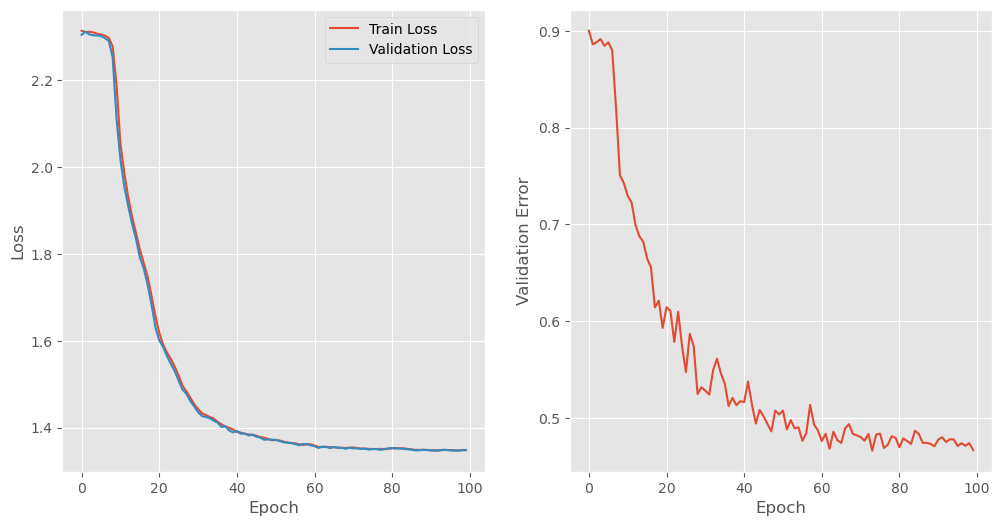

In [105]:
d1 = SoftBoundsReferenceDevice(
    dw_min=1e-3,
    dw_min_dtod=0.3,
    dw_min_std=0,
    w_max_dtod=0,
    w_min_dtod=0,
    slope_down_dtod=0.42,
    slope_up_dtod=0.42,
    write_noise_std=0
)
rpu_config_1 = SingleRPUConfig(device=d1)
print(rpu_config_1)
model_1 = create_network(rpu_config_1, INPUT_SIZE, HIDDEN_SIZES, OUTPUT_SIZE)
print(model_1)

train_set, valid_set, test_set = get_data_loaders()
metrics_1 = train(model_1, train_set, valid_set)
test_evaluation(model_1, test_set)
plot_metrics(metrics_1)

### Model 2: floating point update

SingleRPUConfig(
    runtime=RuntimeParameter(),
    pre_post=PrePostProcessingParameter(input_range=InputRangeParameter(enable=False)),
    mapping=MappingParameter(),
    forward=IOParameters(),
    backward=IOParameters(),
    update=UpdateParameters(pulse_type=PulseType.NONE_WITH_DEVICE),
    device=SoftBoundsReferenceDevice(
        dw_min_std=0,
        w_max_dtod=0,
        w_min_dtod=0,
        slope_up_dtod=0.42,
        slope_down_dtod=0.42
    )
)
AnalogSequential(
  (0): AnalogLinearMapped(
    in_features=784, out_features=256, bias=True, SingleRPUConfig
    (analog_module): TileModuleArray(
      (array): ModuleList(
        (0-1): 2 x ModuleList(
          (0): AnalogTile(RPUCudaPulsed<float>[SoftBoundsReference](256,392))
        )
      )
    )
  )
  (1): Sigmoid()
  (2): AnalogLinearMapped(
    in_features=256, out_features=128, bias=True, SingleRPUConfig
    (analog_module): AnalogTile(RPUCudaPulsed<float>[SoftBoundsReference](128,256))
  )
  (3): Sigmoid()
  (4): An

	- Training loss: 0.7559636510610580
	- Validation loss: 0.6587884497452290
	- Validation accuracy: 0.8053
Epoch 4:
	- Training loss: 0.5882727169990539
	- Validation loss: 0.5326934182580482
	- Validation accuracy: 0.8457
Epoch 5:
	- Training loss: 0.4957164436181387
	- Validation loss: 0.4633982505728590
	- Validation accuracy: 0.8658
Epoch 6:
	- Training loss: 0.4430100611249606
	- Validation loss: 0.4231236146644075
	- Validation accuracy: 0.8763
Epoch 7:
	- Training loss: 0.4090470343629519
	- Validation loss: 0.3945855610865228
	- Validation accuracy: 0.8844
Epoch 8:
	- Training loss: 0.3843769074479739
	- Validation loss: 0.3731462909503186
	- Validation accuracy: 0.8913
Epoch 9:
	- Training loss: 0.3644757664203644
	- Validation loss: 0.3624495081603527
	- Validation accuracy: 0.8935
Epoch 10:
	- Training loss: 0.3503087181448937
	- Validation loss: 0.3493346711422535
	- Validation accuracy: 0.8980
Epoch 11:
	- Training loss: 0.3432422369023164
	- Validation loss: 0.34476573884

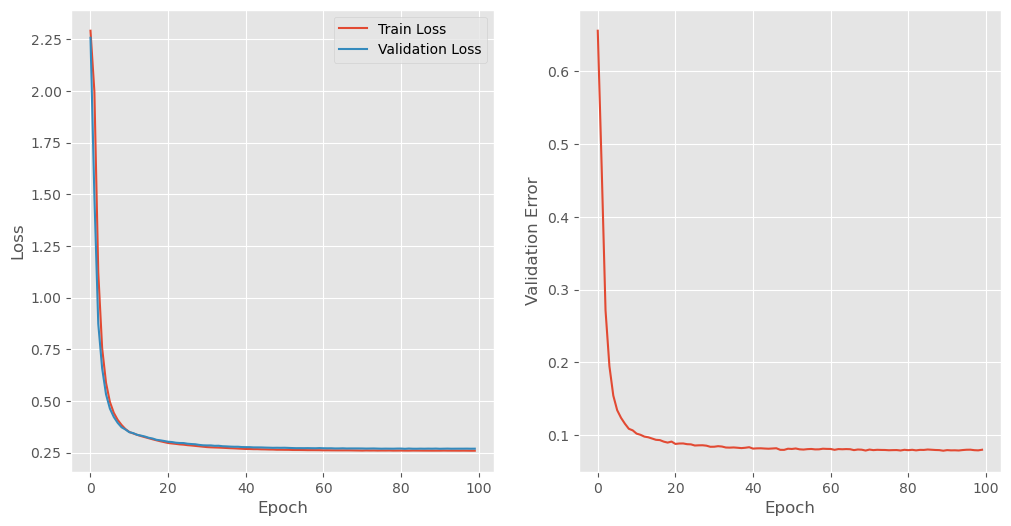

In [106]:
rpu_config_2 = SingleRPUConfig(device=d1, update=UpdateParameters(pulse_type=PulseType('NoneWithDevice')))
print(rpu_config_2)
model_2 = create_network(rpu_config_2, INPUT_SIZE, HIDDEN_SIZES, OUTPUT_SIZE)
print(model_2)

train_set, valid_set, test_set = get_data_loaders()
metrics_2 = train(model_2, train_set, valid_set)
test_evaluation(model_2, test_set)
plot_metrics(metrics_2)

### Model 3: CustomRPUConfig

CustomRPUConfig(
    runtime=RuntimeParameter(),
    pre_post=PrePostProcessingParameter(input_range=InputRangeParameter(enable=False)),
    mapping=MappingParameter(),
    forward=IOParameters(),
    backward=IOParameters(),
    update=CustomUpdateParameters(gradient_noise=1.0)
)
AnalogSequential(
  (0): AnalogLinearMapped(
    in_features=784, out_features=256, bias=True, CustomRPUConfig
    (analog_module): TileModuleArray(
      (array): ModuleList(
        (0-1): 2 x ModuleList(
          (0): CustomTile(
            (tile): CustomSimulatorTile(256, 392, cuda:0)
          )
        )
      )
    )
  )
  (1): Sigmoid()
  (2): AnalogLinearMapped(
    in_features=256, out_features=128, bias=True, CustomRPUConfig
    (analog_module): CustomTile(
      (tile): CustomSimulatorTile(128, 256, cuda:0)
    )
  )
  (3): Sigmoid()
  (4): AnalogLinearMapped(
    in_features=128, out_features=10, bias=True, CustomRPUConfig
    (analog_module): CustomTile(
      (tile): CustomSimulatorTile(10, 1

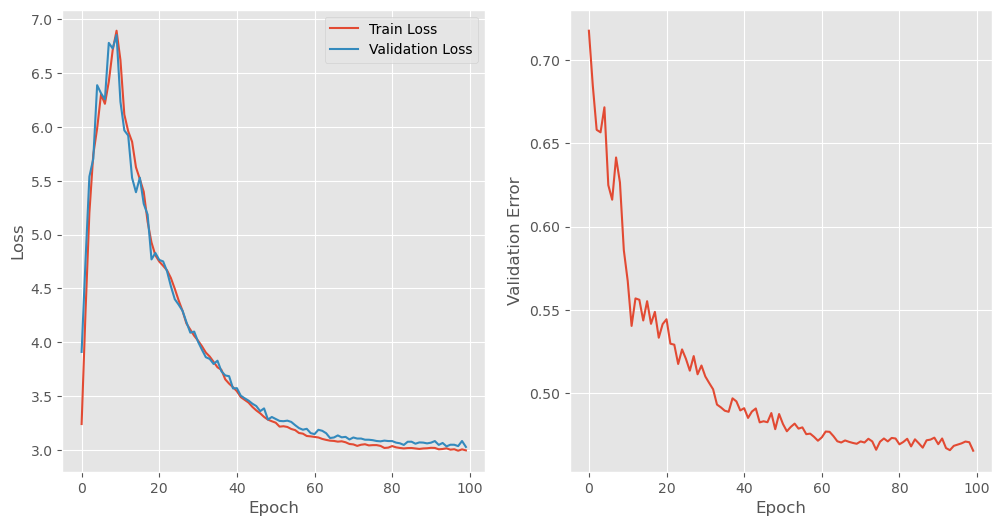

In [6]:
rpu_config_3 = CustomRPUConfig()
rpu_config_3.update.gradient_noise = 1.0
print(rpu_config_3)
model_3 = create_network(rpu_config_3, INPUT_SIZE, HIDDEN_SIZES, OUTPUT_SIZE)
print(model_3)

train_set, valid_set, test_set = get_data_loaders()
metrics_3 = train(model_3, train_set, valid_set)
test_evaluation(model_3, test_set)
plot_metrics(metrics_3)

SoftBoundsReferenceDevice(
    dw_min_std=0,
    w_max_dtod=0,
    w_min_dtod=0,
    write_noise_std=0.3,
    slope_up_dtod=0.42,
    slope_down_dtod=0.42
)


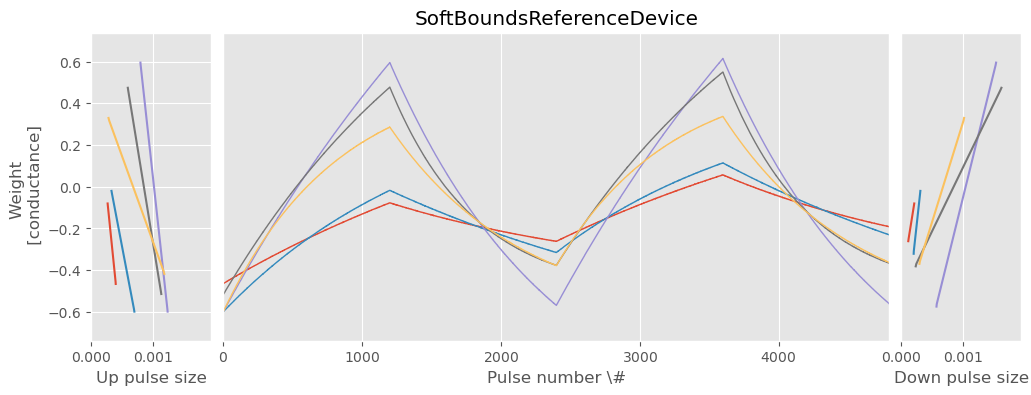

In [108]:
d = SoftBoundsReferenceDevice(
    dw_min=1e-3,
    dw_min_dtod=0.3,
    dw_min_std=0,
    w_max_dtod=0,
    w_min_dtod=0,
    slope_down_dtod=0.42,
    slope_up_dtod=0.42,
    write_noise_std=0.3
)
print(d)
plot_device_compact(d, n_traces=5);